In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# # %%
# import os
# import numpy as np 
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns  
# from PIL import Image
# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader
# import torchvision.transforms as T


# # %%
# train_dir = r'D:\TGS Salt\train'


# # %%
# image_dir = 'train\images'
# mask_dir = 'train\masks'

# # %%
# class SaltDataset(Dataset):
#     def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
#         self.image_dir = image_dir
#         self.mask_dir = mask_dir
#         self.image_transform = image_transform
#         self.mask_transform = mask_transform
#         self.images = os.listdir(image_dir)
#         self.masks = os.listdir(mask_dir)

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.image_dir, self.images[idx])
#         mask_path = os.path.join(self.mask_dir, self.masks[idx])
        
#         image = Image.open(img_path).convert('RGB')
#         mask = Image.open(mask_path).convert('L')

#         if self.image_transform:
#             image = self.image_transform(image)
#         if self.mask_transform:
#             mask = self.mask_transform(mask)

#         return image, mask

# # %%
# image_transform = T.Compose([
#     T.Resize((128, 128)),
#     T.ToTensor(),
#     T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# mask_transform = T.Compose([
#     T.Resize((128, 128)),
#     T.ToTensor(),  # will keep mask as [1, H, W]
# ])


# # %%
# train_dataset = SaltDataset(image_dir,mask_dir,image_transform, mask_transform)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# # %%
# train_dataset[0][0]

# # %%
# import matplotlib.pyplot as plt

# # Pick one sample (e.g., the first one)
# image, mask = train_dataset[20]

# # Convert tensors to numpy arrays for visualization
# # For image: [C, H, W] -> [H, W, C]
# img_np = image.permute(1, 2, 0).cpu().numpy()
# # For mask: [1, H, W] -> [H, W]
# mask_np = mask.squeeze().cpu().numpy()

# # Undo normalization for visualization if needed
# # (If you used normalization in image_transform)
# img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
# img_np = img_np.clip(0, 1)

# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.title("Image")
# plt.imshow(img_np)
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.title("Mask")
# plt.imshow(mask_np, cmap='gray')
# plt.axis('off')

# plt.show()

# # %%
# class Unet(nn.module):
#     def __init__(self):
#         super(Unet, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3,32,3,padding=1),
#             nn.LeakyReLU(),
#             nn.Conv2d(32,32,3,padding=1),
#             nn.LeakyReLU(),
#             nn.MaxPool2d(2),
            
#         )
        




In [8]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

In [ ]:
# !unzip /kaggle/input/tgs-salt-identification-challenge/competition_data.zip

In [ ]:
!unzip /kaggle/input/tgs-salt-identification-challenge/train.zip

In [3]:
len(os.listdir('/kaggle/working/masks'))

4000

In [4]:
image_dir = '/kaggle/working/images'
mask_dir = '/kaggle/working/masks'

68d9f77646.png


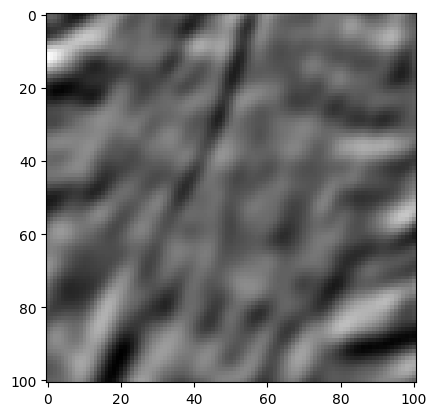

In [6]:
for k in os.listdir(image_dir):
    img = os.path.join(image_dir,k)
    plt.imshow(cv2.imread(img))
    print(k)
    break

68d9f77646.png


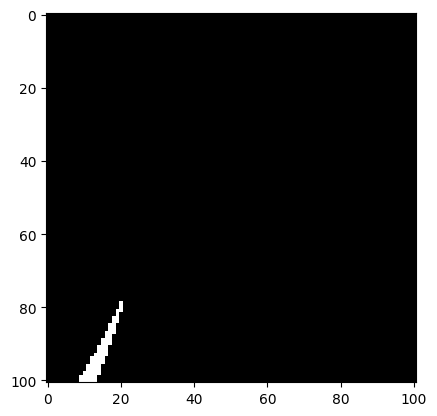

In [7]:
for k in os.listdir(mask_dir):
    img = os.path.join(mask_dir,k)
    plt.imshow(cv2.imread(img))
    print(k)
    break

In [31]:
class SaltDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = os.listdir(image_dir)
        self.masks = os.listdir(mask_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        
        # Load image and mask as grayscale (1 channel)
        image = Image.open(img_path).convert('L')  # Grayscale image
        mask = Image.open(mask_path).convert('L')  # Grayscale mask

        # Apply transforms if provided
        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        # Convert to tensors if still a PIL Image
        if isinstance(image, Image.Image):
            image = np.array(image, dtype=np.float32) / 255.0
            image = torch.from_numpy(image).unsqueeze(0)  # [1, H, W]
        if isinstance(mask, Image.Image):
            mask = np.array(mask, dtype=np.float32) / 255.0
            mask = torch.from_numpy(mask).unsqueeze(0)    # [1, H, W]

        # If mask has 3 channels after transform, convert to 1 channel
        if isinstance(mask, torch.Tensor) and mask.shape[0] == 3:
            mask = mask.mean(dim=0, keepdim=True)  # Average across channels to get [1, H, W]

        # If image has 3 channels after transform, convert to 1 channel (just in case)
        if isinstance(image, torch.Tensor) and image.shape[0] == 3:
            image = image.mean(dim=0, keepdim=True)  # Average across channels to get [1, H, W]

        return image, mask

# %%
image_transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

mask_transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),  # will keep mask as [1, H, W]
])

In [32]:
# %%
train_dataset = SaltDataset(image_dir,mask_dir,image_transform, mask_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [33]:
train_dataset[100][0].shape

RuntimeError: output with shape [1, 128, 128] doesn't match the broadcast shape [3, 128, 128]

In [34]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Helper function to create a convolutional block
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        # Contracting Path (Encoder)
        self.enc1 = conv_block(1, 32)   # Input: 128x128x1, Output: 128x128x32
        self.pool1 = nn.MaxPool2d(2)   # Output: 64x64x32
        self.enc2 = conv_block(32, 64)  # Output: 64x64x64
        self.pool2 = nn.MaxPool2d(2)   # Output: 32x32x64
        self.enc3 = conv_block(64, 128) # Output: 32x32x128
        self.pool3 = nn.MaxPool2d(2)   # Output: 16x16x128

        # Bottleneck
        self.bottleneck = conv_block(128, 256)  # Output: 16x16x256

        # Expanding Path (Decoder)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  # Output: 32x32x128
        self.dec3 = conv_block(256, 128)  # Concat 128 (up) + 128 (skip) = 256, Output: 32x32x128
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)   # Output: 64x64x64
        self.dec2 = conv_block(128, 64)   # Concat 64 (up) + 64 (skip) = 128, Output: 64x64x64
        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)    # Output: 128x128x32
        self.dec1 = conv_block(64, 32)    # Concat 32 (up) + 32 (skip) = 64, Output: 128x128x32

        # Output Layer
        self.final_conv = nn.Conv2d(32, 1, kernel_size=1)  # Output: 128x128x1

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)       # 128x128x32
        pool1 = self.pool1(enc1)  # 64x64x32
        enc2 = self.enc2(pool1)   # 64x64x64
        pool2 = self.pool2(enc2)  # 32x32x64
        enc3 = self.enc3(pool2)   # 32x32x128
        pool3 = self.pool3(enc3)  # 16x16x128

        # Bottleneck
        bottleneck = self.bottleneck(pool3)  # 16x16x256

        # Decoder with Skip Connections
        up3 = self.upconv3(bottleneck)        # 32x32x128
        merge3 = torch.cat([up3, enc3], dim=1)  # 32x32x256 (128 + 128)
        dec3 = self.dec3(merge3)              # 32x32x128
        up2 = self.upconv2(dec3)              # 64x64x64
        merge2 = torch.cat([up2, enc2], dim=1)  # 64x64x128 (64 + 64)
        dec2 = self.dec2(merge2)              # 64x64x64
        up1 = self.upconv1(dec2)              # 128x128x32
        merge1 = torch.cat([up1, enc1], dim=1)  # 128x128x64 (32 + 32)
        dec1 = self.dec1(merge1)              # 128x128x32

        # Output
        out = self.final_conv(dec1)           # 128x128x1
        return torch.sigmoid(out)             # Probabilities [0, 1]

# Test the model
if __name__ == "__main__":
    model = UNet()
    x = torch.randn(1, 1, 128, 128)  # Batch of 1, 1 channel, 128x128
    y = model(x)
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {y.shape}")

Input shape: torch.Size([1, 1, 128, 128])
Output shape: torch.Size([1, 1, 128, 128])


In [19]:
# Assuming SaltDataset is defined as before
from torch.utils.data import DataLoader
import torch.optim as optim


# Model, Loss, and Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)  # Or use the basic UNet()
criterion = nn.BCELoss()  # Binary Cross-Entropy for binary segmentation
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop (Basic)
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader):.4f}")

RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[32, 3, 128, 128] to have 1 channels, but got 3 channels instead